# Training Notebook

Notebook for training and evaluating models using the preprocessed dataframe

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from pathlib import Path

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from scipy.sparse import hstack, csr_matrix
from scipy.stats import randint, uniform
from sklearn.metrics import (
    classification_report, f1_score, average_precision_score,
    hamming_loss, jaccard_score, precision_score, recall_score,
    confusion_matrix
)

from skmultilearn.model_selection import iterative_train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import ParameterSampler


warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

TARGET_TAGS = ['math', 'graphs', 'strings', 'number theory', 'trees',
               'geometry', 'games', 'probabilities']
RANDOM_STATE = 42

CODEBERT_MODEL = 'microsoft/codebert-base'
MAX_CODE_LENGTH = 512
OUTPUT_DIR = Path('models')
OUTPUT_DIR.mkdir(exist_ok=True)

## 0. Loading pre-processed dataframe

In [83]:
PREPROCESSED_OUTPUT_FILE = "data/preprocessed_dataset.parquet" 
df = pd.read_parquet(PREPROCESSED_OUTPUT_FILE)
df["tags_list"] = df["tags_list"].apply(list)

## 1. Data Preparation

In [84]:
# Create binary labels
for tag in TARGET_TAGS:
    df[f'label_{tag}'] = df['tags_list'].apply(
        lambda x: 1 if isinstance(x, list) and tag in x else 0
    )

y = df[[f'label_{tag}' for tag in TARGET_TAGS]].values

print(f"\nDataset: {len(df)} samples, {len(TARGET_TAGS)} tags")

# Train/Val/Test split (for handling imblance, we use iterative train, test, split)
# We don't use K-fold cross-validation (few samples)
X_indices = np.arange(len(df)).reshape(-1, 1) #
X_trainval_idx, y_trainval, X_test_idx, y_test = iterative_train_test_split(
    X_indices, y, test_size=0.2
)
X_train_idx, y_train, X_val_idx, y_val = iterative_train_test_split(
    X_trainval_idx, y_trainval, test_size=0.25
)

train_idx = X_train_idx.ravel()
val_idx = X_val_idx.ravel()
test_idx = X_test_idx.ravel()

print(f"Split: Train={len(train_idx)} | Val={len(val_idx)} | Test={len(test_idx)}")



Dataset: 2678 samples, 8 tags
Split: Train=1614 | Val=536 | Test=528


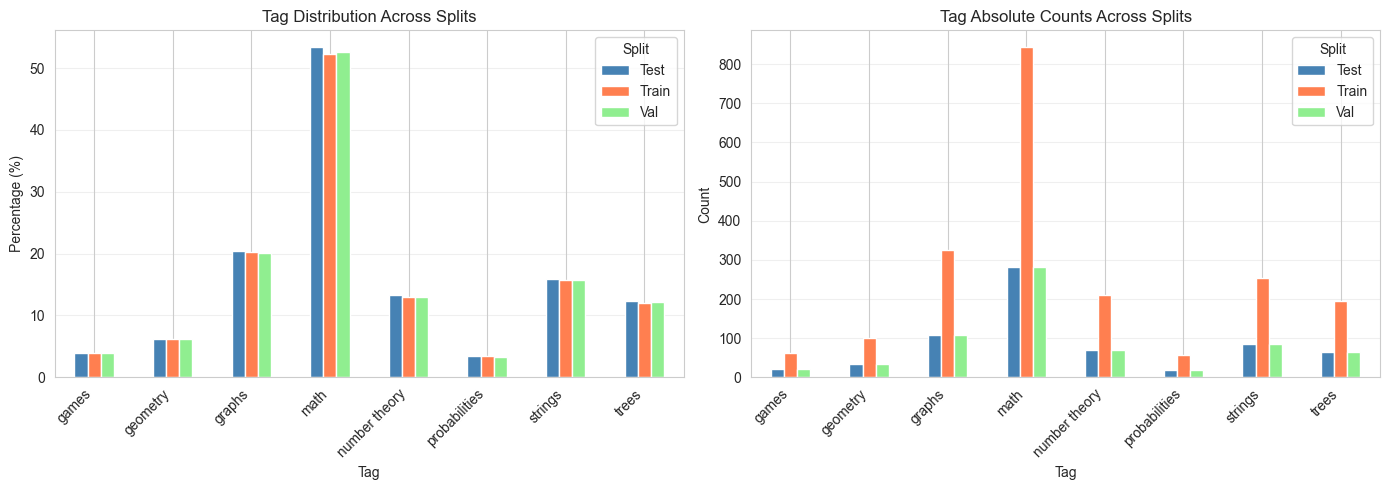

In [85]:
# Distribution by split
split_distributions = []
for split_name, indices in [('Train', train_idx), ('Val', val_idx), ('Test', test_idx)]:
    for i, tag in enumerate(TARGET_TAGS):
        count = y[indices, i].sum()
        split_distributions.append({
            'Split': split_name,
            'Tag': tag,
            'Count': count,
            'Percentage': count / len(indices) * 100
        })

split_df = pd.DataFrame(split_distributions)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = axes[0]
split_pivot = split_df.pivot(index='Tag', columns='Split', values='Percentage')
split_pivot.plot(kind='bar', ax=ax, color=['steelblue', 'coral', 'lightgreen'])
ax.set_ylabel('Percentage (%)')
ax.set_title('Tag Distribution Across Splits')
ax.set_xlabel('Tag')
ax.legend(title='Split')
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Absolute counts
ax = axes[1]
split_pivot_counts = split_df.pivot(index='Tag', columns='Split', values='Count')
split_pivot_counts.plot(kind='bar', ax=ax, color=['steelblue', 'coral', 'lightgreen'])
ax.set_ylabel('Count')
ax.set_title('Tag Absolute Counts Across Splits')
ax.set_xlabel('Tag')
ax.legend(title='Split')
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 2. Text-only models

I first tried as input for prediction the problem description only (with the problem description notes if available). Specifically, I used tf-idf to extract features from these. I then tried (in the next section) adding other features extracted from "source_code" and "difficulty".

In [74]:
pd.set_option('display.max_colwidth', 200)

In [86]:
# TF-IDF Features
stop_words = list(ENGLISH_STOP_WORDS) + [
    'problem', 'input', 'output', 'test', 'case', 'example', 'note', 'notein'
] # I added some words that I noticed coming back a lot

tfidf = TfidfVectorizer( # I selected these after trying several values and checking the resulting features
    max_features=3000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.7,
    stop_words=stop_words
)

# df.prob_desc_description is already pre-processed (specifically tokenized)
X_desc = df['prob_desc_description'].fillna('')
X_train_text = tfidf.fit_transform(X_desc.iloc[train_idx])
X_val_text = tfidf.transform(X_desc.iloc[val_idx])
X_test_text = tfidf.transform(X_desc.iloc[test_idx])

print(f"TF-IDF features: {X_train_text.shape[1]}")

# For results
text_only_results = {}


TF-IDF features: 3000


In [88]:
#  Logistic Regression

print("Training Logistic Regression with hyperparameter tuning")

# Grid of hyperparameters to test
param_grid_lr = {
    'C': [0.1, 0.5, 1.0, 5.0, 10.0],
    'max_iter': [500, 1000]
}

# Evaluate each combination on validation set using macro F1 across all tags
best_val_f1_lr = 0
best_params_lr = None

for C in param_grid_lr['C']:
    for max_iter in param_grid_lr['max_iter']:
        # Train models for all tags
        models_temp = []
        for i in range(len(TARGET_TAGS)):
            model = LogisticRegression(
                C=C,
                max_iter=max_iter,
                class_weight='balanced',
                random_state=RANDOM_STATE,
                solver='saga'
            )
            model.fit(X_train_text, y_train[:, i])
            models_temp.append(model)
        
        # Evaluate on validation (all tags)
        y_val_pred_temp = np.column_stack([m.predict(X_val_text) for m in models_temp])
        val_f1 = f1_score(y_val, y_val_pred_temp, average='macro', zero_division=0)
        
        if val_f1 > best_val_f1_lr:
            best_val_f1_lr = val_f1
            best_params_lr = {'C': C, 'max_iter': max_iter}

print(f"Best params (macro F1={best_val_f1_lr:.4f}): C={best_params_lr['C']:.3f}, max_iter={best_params_lr['max_iter']}")

lr_models_text = []
for i, tag in enumerate(TARGET_TAGS):
    model = LogisticRegression(
        C=best_params_lr['C'],
        max_iter=best_params_lr['max_iter'],
        class_weight='balanced',
        random_state=RANDOM_STATE,
        solver='saga'
    )
    model.fit(X_train_text, y_train[:, i])
    lr_models_text.append(model)

# Evaluate on validation
y_val_pred_lr = np.column_stack([m.predict(X_val_text) for m in lr_models_text])
y_val_proba_lr = np.column_stack([m.predict_proba(X_val_text)[:, 1] for m in lr_models_text])

lr_f1_val = f1_score(y_val, y_val_pred_lr, average='macro', zero_division=0)
lr_ap_val = np.mean([average_precision_score(y_val[:, i], y_val_proba_lr[:, i])
                     for i in range(len(TARGET_TAGS)) if y_val[:, i].sum() > 0])

print(f"Validation - Macro F1: {lr_f1_val:.4f} | Mean AP: {lr_ap_val:.4f}")

# Evaluate on test
y_test_pred_lr = np.column_stack([m.predict(X_test_text) for m in lr_models_text])
y_test_proba_lr = np.column_stack([m.predict_proba(X_test_text)[:, 1] for m in lr_models_text])

lr_f1 = f1_score(y_test, y_test_pred_lr, average='macro', zero_division=0)
lr_ap = np.mean([average_precision_score(y_test[:, i], y_test_proba_lr[:, i])
                 for i in range(len(TARGET_TAGS)) if y_test[:, i].sum() > 0])

text_only_results['Logistic Regression'] = {
    'macro_f1': lr_f1,
    'mean_ap': lr_ap,
    'val_f1': lr_f1_val,
    'per_tag_f1': [f1_score(y_test[:, i], y_test_pred_lr[:, i], zero_division=0)
                   for i in range(len(TARGET_TAGS))]
}

print(f"Test - Macro F1: {lr_f1:.4f} | Mean AP: {lr_ap:.4f}")


Training Logistic Regression with hyperparameter tuning
Best params (macro F1=0.6402): C=5.000, max_iter=1000
Validation - Macro F1: 0.6402 | Mean AP: 0.6837
Test - Macro F1: 0.5810 | Mean AP: 0.6483


In [89]:

# Random Forest

print("Training Random Forest")
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [15, 20, 30],
    'min_samples_split': [2, 5, 10]
}

best_val_f1_rf = 0
best_params_rf = None

for n_est in param_grid_rf['n_estimators']:
    for max_d in param_grid_rf['max_depth']:
        for min_split in param_grid_rf['min_samples_split']:
            model = RandomForestClassifier(
                n_estimators=n_est,
                max_depth=max_d,
                min_samples_split=min_split,
                class_weight='balanced',
                random_state=RANDOM_STATE,
                n_jobs=-1
            )
            model.fit(X_train_text, y_train[:, 0])
            
            y_val_pred_temp = model.predict(X_val_text)
            val_f1 = f1_score(y_val[:, 0], y_val_pred_temp, zero_division=0)
            
            if val_f1 > best_val_f1_rf:
                best_val_f1_rf = val_f1
                best_params_rf = {
                    'n_estimators': n_est,
                    'max_depth': max_d,
                    'min_samples_split': min_split
                }

print(f"Best params (selected on validation): {best_params_rf}")

rf_models_text = []
for i, tag in enumerate(TARGET_TAGS):
    model = RandomForestClassifier(
        n_estimators=best_params_rf['n_estimators'],
        max_depth=best_params_rf['max_depth'],
        min_samples_split=best_params_rf['min_samples_split'],
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train_text, y_train[:, i])
    rf_models_text.append(model)

# Validation
y_val_pred_rf = np.column_stack([m.predict(X_val_text) for m in rf_models_text])
y_val_proba_rf = np.column_stack([m.predict_proba(X_val_text)[:, 1] for m in rf_models_text])

rf_f1_val = f1_score(y_val, y_val_pred_rf, average='macro', zero_division=0)
rf_ap_val = np.mean([average_precision_score(y_val[:, i], y_val_proba_rf[:, i])
                     for i in range(len(TARGET_TAGS)) if y_val[:, i].sum() > 0])

print(f"Validation - Macro F1: {rf_f1_val:.4f} | Mean AP: {rf_ap_val:.4f}")

# Test
y_test_pred_rf = np.column_stack([m.predict(X_test_text) for m in rf_models_text])
y_test_proba_rf = np.column_stack([m.predict_proba(X_test_text)[:, 1] for m in rf_models_text])

rf_f1 = f1_score(y_test, y_test_pred_rf, average='macro', zero_division=0)
rf_ap = np.mean([average_precision_score(y_test[:, i], y_test_proba_rf[:, i])
                 for i in range(len(TARGET_TAGS)) if y_test[:, i].sum() > 0])

text_only_results['Random Forest'] = {
    'macro_f1': rf_f1,
    'mean_ap': rf_ap,
    'val_f1': rf_f1_val,
    'per_tag_f1': [f1_score(y_test[:, i], y_test_pred_rf[:, i], zero_division=0)
                   for i in range(len(TARGET_TAGS))]
}

print(f"Test - Macro F1: {rf_f1:.4f} | Mean AP: {rf_ap:.4f}")


Training Random Forest
Best params (selected on validation): {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 5}
Validation - Macro F1: 0.6415 | Mean AP: 0.7809
Test - Macro F1: 0.5890 | Mean AP: 0.7557


In [90]:
# XGBoost
param_grid_xgb = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [150, 200]
}

best_val_f1_xgb = 0
best_params_xgb = None

n_pos = y_train[:, 0].sum()
n_neg = len(y_train) - n_pos
scale_weight = n_neg / n_pos

for max_d in param_grid_xgb['max_depth']:
    for lr in param_grid_xgb['learning_rate']:
        for n_est in param_grid_xgb['n_estimators']:
            model = XGBClassifier(
                n_estimators=n_est,
                max_depth=max_d,
                learning_rate=lr,
                scale_pos_weight=scale_weight,
                random_state=RANDOM_STATE,
                eval_metric='logloss',
                use_label_encoder=False,
                tree_method='hist'
            )
            model.fit(X_train_text, y_train[:, 0], verbose=False)
            
            y_val_pred_temp = model.predict(X_val_text)
            val_f1 = f1_score(y_val[:, 0], y_val_pred_temp, zero_division=0)
            
            if val_f1 > best_val_f1_xgb:
                best_val_f1_xgb = val_f1
                best_params_xgb = {
                    'n_estimators': n_est,
                    'max_depth': max_d,
                    'learning_rate': lr
                }

print(f"Best params (selected on validation): {best_params_xgb}")

xgb_models_text = []
for i, tag in enumerate(TARGET_TAGS):
    n_pos = y_train[:, i].sum()
    n_neg = len(y_train) - n_pos
    
    if n_pos == 0 or n_neg == 0:
        xgb_models_text.append(None)
        continue
    
    scale_weight = n_neg / n_pos
    
    model = XGBClassifier(
        n_estimators=best_params_xgb['n_estimators'],
        max_depth=best_params_xgb['max_depth'],
        learning_rate=best_params_xgb['learning_rate'],
        scale_pos_weight=scale_weight,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        use_label_encoder=False,
        tree_method='hist'
    )
    model.fit(X_train_text, y_train[:, i], verbose=False)
    xgb_models_text.append(model)

# Validation
y_val_pred_xgb = np.column_stack([
    m.predict(X_val_text) if m is not None else np.zeros(len(y_val))
    for m in xgb_models_text
])
y_val_proba_xgb = np.column_stack([
    m.predict_proba(X_val_text)[:, 1] if m is not None else np.zeros(len(y_val))
    for m in xgb_models_text
])

xgb_f1_val = f1_score(y_val, y_val_pred_xgb, average='macro', zero_division=0)
xgb_ap_val = np.mean([average_precision_score(y_val[:, i], y_val_proba_xgb[:, i])
                      for i in range(len(TARGET_TAGS)) if y_val[:, i].sum() > 0])

print(f"Validation - Macro F1: {xgb_f1_val:.4f} | Mean AP: {xgb_ap_val:.4f}")

# Test
y_test_pred_xgb = np.column_stack([
    m.predict(X_test_text) if m is not None else np.zeros(len(y_test))
    for m in xgb_models_text
])
y_test_proba_xgb = np.column_stack([
    m.predict_proba(X_test_text)[:, 1] if m is not None else np.zeros(len(y_test))
    for m in xgb_models_text
])

xgb_f1 = f1_score(y_test, y_test_pred_xgb, average='macro', zero_division=0)
xgb_ap = np.mean([average_precision_score(y_test[:, i], y_test_proba_xgb[:, i])
                  for i in range(len(TARGET_TAGS)) if y_test[:, i].sum() > 0])

text_only_results['XGBoost'] = {
    'macro_f1': xgb_f1,
    'mean_ap': xgb_ap,
    'val_f1': xgb_f1_val,
    'per_tag_f1': [f1_score(y_test[:, i], y_test_pred_xgb[:, i], zero_division=0)
                   for i in range(len(TARGET_TAGS))]
}

print(f"Test - Macro F1: {xgb_f1:.4f} | Mean AP: {xgb_ap:.4f}")

Best params (selected on validation): {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1}
Validation - Macro F1: 0.7207 | Mean AP: 0.7634
Test - Macro F1: 0.6972 | Mean AP: 0.7083


In [91]:

# CatBoost
print(" Training CatBoost with hyperparameter tuning")

param_grid_cb = {
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'iterations': [150, 200]
}

best_val_f1_cb = 0
best_params_cb = None

n_pos = y_train[:, 0].sum()
n_neg = len(y_train) - n_pos
class_weights = {0: 1.0, 1: n_neg / n_pos}

for depth in param_grid_cb['depth']:
    for lr in param_grid_cb['learning_rate']:
        for iters in param_grid_cb['iterations']:
            model = CatBoostClassifier(
                iterations=iters,
                depth=depth,
                learning_rate=lr,
                class_weights=class_weights,
                random_seed=RANDOM_STATE,
                verbose=False
            )
            model.fit(X_train_text, y_train[:, 0])
            
            y_val_pred_temp = model.predict(X_val_text)
            val_f1 = f1_score(y_val[:, 0], y_val_pred_temp, zero_division=0)
            
            if val_f1 > best_val_f1_cb:
                best_val_f1_cb = val_f1
                best_params_cb = {
                    'iterations': iters,
                    'depth': depth,
                    'learning_rate': lr
                }

print(f"Best params (selected on validation): {best_params_cb}")

cb_models_text = []
for i, tag in enumerate(TARGET_TAGS):
    n_pos = y_train[:, i].sum()
    n_neg = len(y_train) - n_pos
    
    if n_pos == 0 or n_neg == 0:
        cb_models_text.append(None)
        continue
    
    class_weights = {0: 1.0, 1: n_neg / n_pos}
    
    model = CatBoostClassifier(
        iterations=best_params_cb['iterations'],
        depth=best_params_cb['depth'],
        learning_rate=best_params_cb['learning_rate'],
        class_weights=class_weights,
        random_seed=RANDOM_STATE,
        verbose=False
    )
    model.fit(X_train_text, y_train[:, i])
    cb_models_text.append(model)

# Validation
y_val_pred_cb = np.column_stack([
    m.predict(X_val_text) if m is not None else np.zeros(len(y_val))
    for m in cb_models_text
])
y_val_proba_cb = np.column_stack([
    m.predict_proba(X_val_text)[:, 1] if m is not None else np.zeros(len(y_val))
    for m in cb_models_text
])

cb_f1_val = f1_score(y_val, y_val_pred_cb, average='macro', zero_division=0)
cb_ap_val = np.mean([average_precision_score(y_val[:, i], y_val_proba_cb[:, i])
                     for i in range(len(TARGET_TAGS)) if y_val[:, i].sum() > 0])

print(f"Validation - Macro F1: {cb_f1_val:.4f} | Mean AP: {cb_ap_val:.4f}")

# Test
y_test_pred_cb = np.column_stack([
    m.predict(X_test_text) if m is not None else np.zeros(len(y_test))
    for m in cb_models_text
])
y_test_proba_cb = np.column_stack([
    m.predict_proba(X_test_text)[:, 1] if m is not None else np.zeros(len(y_test))
    for m in cb_models_text
])

cb_f1 = f1_score(y_test, y_test_pred_cb, average='macro', zero_division=0)
cb_ap = np.mean([average_precision_score(y_test[:, i], y_test_proba_cb[:, i])
                 for i in range(len(TARGET_TAGS)) if y_test[:, i].sum() > 0])

text_only_results['CatBoost'] = {
    'macro_f1': cb_f1,
    'mean_ap': cb_ap,
    'val_f1': cb_f1_val,
    'per_tag_f1': [f1_score(y_test[:, i], y_test_pred_cb[:, i], zero_division=0)
                   for i in range(len(TARGET_TAGS))]
}

print(f"Test - Macro F1: {cb_f1:.4f} | Mean AP: {cb_ap:.4f}")

print("\n" + "-" * 80)
print("TEXT-ONLY SUMMARY")
print("-" * 80)
for model_name, results in text_only_results.items():
    print(f"{model_name:<25} Val F1: {results['val_f1']:.4f} | Test F1: {results['macro_f1']:.4f} | Test AP: {results['mean_ap']:.4f}")


 Training CatBoost with hyperparameter tuning
Best params (selected on validation): {'iterations': 150, 'depth': 4, 'learning_rate': 0.05}
Validation - Macro F1: 0.7030 | Mean AP: 0.7534
Test - Macro F1: 0.6938 | Mean AP: 0.7311

--------------------------------------------------------------------------------
TEXT-ONLY SUMMARY
--------------------------------------------------------------------------------
Logistic Regression       Val F1: 0.6402 | Test F1: 0.5810 | Test AP: 0.6483
Random Forest             Val F1: 0.6415 | Test F1: 0.5890 | Test AP: 0.7557
XGBoost                   Val F1: 0.7207 | Test F1: 0.6972 | Test AP: 0.7083
CatBoost                  Val F1: 0.7030 | Test F1: 0.6938 | Test AP: 0.7311


In [80]:
for model_name, results in text_only_results.items():
    print(f"{model_name:<25} Val F1: {results['val_f1']:.4f} | Test F1: {results['macro_f1']:.4f} | Test AP: {results['mean_ap']:.4f}")

Logistic Regression       Val F1: 0.5435 | Test F1: 0.5404 | Test AP: 0.6262
Random Forest             Val F1: 0.6425 | Test F1: 0.6450 | Test AP: 0.7543
XGBoost                   Val F1: 0.6875 | Test F1: 0.7029 | Test AP: 0.7241
CatBoost                  Val F1: 0.6896 | Test F1: 0.7020 | Test AP: 0.7327


## 3. Using Other features

Here, I tried improving results by using additional features. In particular, I wanted to include "difficulty" as I saw from eda that some tags could be associated to more difficult problems than others. I also added "source_code". For these, I didn't use tf-idf (more difficult to tune, adapt to the specifics of code) and used directly a code-specific embedding model.

In [98]:
PREPROCESSED_OUTPUT_FILE = "data/preprocessed_dataset.parquet" 
df = pd.read_parquet(PREPROCESSED_OUTPUT_FILE)
df["tags_list"] = df["tags_list"].apply(list)

In [100]:
# Create binary labels
for tag in TARGET_TAGS:
    df[f'label_{tag}'] = df['tags_list'].apply(
        lambda x: 1 if isinstance(x, list) and tag in x else 0
    )

# Handle difficulty
df['difficulty_clean'] = df['difficulty'].replace(-1, np.nan)
median_diff = df['difficulty_clean'].median()
df['difficulty_clean'] = df['difficulty_clean'].fillna(median_diff)

# Prepare features and labels
y = df[[f'label_{tag}' for tag in TARGET_TAGS]].values

print(f"Dataset: {len(df)} samples, {len(TARGET_TAGS)} tags")
print(f"Difficulty range: [{df['difficulty_clean'].min():.0f}, {df['difficulty_clean'].max():.0f}]")

Dataset: 2678 samples, 8 tags
Difficulty range: [800, 3500]


In [103]:
# TF-IDF (same as previous section)
print("Extracting TF-IDF features.")
stop_words = list(ENGLISH_STOP_WORDS) + [
    'problem', 'input', 'output', 'test', 'case', 'example', "note", "notein"
]

tfidf = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.7,
    stop_words=stop_words
)

X_desc = df['prob_desc_description'].fillna('')
X_train_tfidf = tfidf.fit_transform(X_desc.iloc[train_idx])
X_val_tfidf = tfidf.transform(X_desc.iloc[val_idx])
X_test_tfidf = tfidf.transform(X_desc.iloc[test_idx])

Extracting TF-IDF features.


In [ ]:
# CodeBERT
print("Extracting CodeBERT embeddings")
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print(f"  Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained(CODEBERT_MODEL)
codebert = AutoModel.from_pretrained(CODEBERT_MODEL).to(device)
codebert.eval()

def extract_embeddings(indices, batch_size=32):
    embeddings = []
    codes = df['source_code'].fillna('').iloc[indices].values
    
    for i in range(0, len(codes), batch_size):
        batch = codes[i:i+batch_size]
        
        # Filter out empty strings
        valid_codes = [code if len(code.strip()) > 0 else "" for code in batch]
        
        # Tokenize the ENTIRE batch at once
        inputs = tokenizer(
            valid_codes, 
            max_length=MAX_CODE_LENGTH, 
            truncation=True,
            padding='max_length', 
            return_tensors='pt'
        ).to(device)
        
        # Single forward pass for the whole batch
        with torch.no_grad():
            outputs = codebert(**inputs)
            # Extract [CLS] token embeddings for all examples
            batch_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        
        embeddings.append(batch_emb)
    
    return np.vstack(embeddings)

X_train_code = extract_embeddings(train_idx)
X_val_code = extract_embeddings(val_idx)
X_test_code = extract_embeddings(test_idx)

print(f"  CodeBERT: {X_train_code.shape[1]} features")


In [104]:

# Difficulty
scaler = StandardScaler()
X_train_diff = scaler.fit_transform(df['difficulty_clean'].iloc[train_idx].values.reshape(-1, 1))
X_val_diff = scaler.transform(df['difficulty_clean'].iloc[val_idx].values.reshape(-1, 1))
X_test_diff = scaler.transform(df['difficulty_clean'].iloc[test_idx].values.reshape(-1, 1))

print(f"  Difficulty: {X_train_diff.shape[1]} feature")

# Combine
X_train = hstack([X_train_tfidf, csr_matrix(X_train_code), csr_matrix(X_train_diff)])
X_val = hstack([X_val_tfidf, csr_matrix(X_val_code), csr_matrix(X_val_diff)])
X_test = hstack([X_test_tfidf, csr_matrix(X_test_code), csr_matrix(X_test_diff)])

print(f"\nCombined features: {X_train.shape[1]} dimensions")


  Difficulty: 1 feature

Combined features: 3769 dimensions


In [102]:
train_idx

array([   2,    5,    8, ..., 2675, 2676, 2677], shape=(1614,))

In [105]:
# Training the model (we use xgboost, one model per tag)

models = []

for i, tag in enumerate(TARGET_TAGS):
    n_pos = y_train[:, i].sum()
    n_neg = len(y_train) - n_pos
    scale_weight = n_neg / n_pos if n_pos > 0 else 1.0
    
    model = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_weight,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        use_label_encoder=False,
        tree_method='hist'
    )
    
    model.fit(X_train, y_train[:, i], verbose=False)
    models.append(model)
    print(f"  Trained {tag:15s} (scale_pos_weight={scale_weight:.2f})")


  Trained math            (scale_pos_weight=0.91)
  Trained graphs          (scale_pos_weight=3.95)
  Trained strings         (scale_pos_weight=5.35)
  Trained number theory   (scale_pos_weight=6.69)
  Trained trees           (scale_pos_weight=7.32)
  Trained geometry        (scale_pos_weight=15.14)
  Trained games           (scale_pos_weight=24.62)
  Trained probabilities   (scale_pos_weight=27.82)


In [ ]:
# Training with hyperparameter tuning using validation set

param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2]
}
best_macro_f1 = 0
best_params = None

# Random search with 3 iterations
n_iter = 3
param_list = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=RANDOM_STATE))

for params in param_list:
    base_clf = XGBClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        use_label_encoder=False,
        tree_method='hist'
    )
    
    model = MultiOutputClassifier(base_clf)
    model.fit(X_train, y_train)
    
    y_val_pred = model.predict(X_val)
    macro_f1 = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
    
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_params = params
    
    print(f"Params: {params} -> Macro F1: {macro_f1:.4f}")

print(f"\nBest Params: {best_params}")
print(f"Best Validation Macro F1: {best_macro_f1:.4f}")


In [115]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1334234 stored elements and shape (1614, 3769)>

In [ ]:
# Train final model on train + validation with best hyperparameters
from scipy.sparse import vstack as sparse_vstack

X_train_val = sparse_vstack([X_train, X_val])
y_train_val = np.vstack([y_train, y_val])

base_clf = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False,
    tree_method='hist'
)

model = MultiOutputClassifier(base_clf)
model.fit(X_train_val, y_train_val)

print("Final model trained on train + validation set")


Final model trained on train + validation set


In [120]:
# Compute validation metrics with best model
print("\n[Computing Validation Metrics with Best Model]")
base_clf = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False,
    tree_method='hist'
)

best_model = MultiOutputClassifier(base_clf)
best_model.fit(X_train, y_train)

y_val_pred = best_model.predict(X_val)
y_val_proba = np.column_stack([
    estimator.predict_proba(X_val)[:, 1] for estimator in best_model.estimators_
])

macro_f1 = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
mean_ap = np.mean([
    average_precision_score(y_val[:, i], y_val_proba[:, i])
    for i in range(len(TARGET_TAGS)) if y_val[:, i].sum() > 0
])
hamming = hamming_loss(y_val, y_val_pred)
jaccard = jaccard_score(y_val, y_val_pred, average='micro')


[Computing Validation Metrics with Best Model]


We then evaluate on the test set

In [ ]:
print("Test Set Evaluation")

from sklearn.metrics import (
    classification_report, f1_score, average_precision_score,
    hamming_loss, jaccard_score, precision_score, recall_score
)

y_test_pred = model.predict(X_test)
y_test_proba = np.column_stack([
    estimator.predict_proba(X_test)[:, 1] for estimator in model.estimators_
])

# Overall metrics
test_macro_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
test_mean_ap = np.mean([
    average_precision_score(y_test[:, i], y_test_proba[:, i])
    for i in range(len(TARGET_TAGS)) if y_test[:, i].sum() > 0
])
test_hamming = hamming_loss(y_test, y_test_pred)
test_jaccard = jaccard_score(y_test, y_test_pred, average='micro')

print(f"\nTest Set - Overall Metrics:")
print(f" Macro F1: {test_macro_f1:.4f}")
print(f" Mean Avg Precision: {test_mean_ap:.4f}")
print(f" Hamming Loss: {test_hamming:.4f}")
print(f" Jaccard Similarity: {test_jaccard:.4f}")
print("\nTest Set (Per-Tag Performance) :")
print(classification_report(y_test, y_test_pred, target_names=TARGET_TAGS, digits=3))

# Per-tag F1 scores
per_tag_f1 = [
    f1_score(y_test[:, i], y_test_pred[:, i], zero_division=0)
    for i in range(len(TARGET_TAGS))
]

Test Set Evaluation

Test Set - Overall Metrics:
 Macro F1: 0.6659
 Mean Avg Precision: 0.7623
 Hamming Loss: 0.0845
 Jaccard Similarity: 0.5429

Test Set - Per-Tag Performance:
               precision    recall  f1-score   support

         math      0.805     0.748     0.776       282
       graphs      0.708     0.472     0.567       108
      strings      0.829     0.750     0.787        84
number theory      0.789     0.214     0.337        70
        trees      0.875     0.646     0.743        65
     geometry      0.895     0.515     0.654        33
        games      0.889     0.762     0.821        21
probabilities      0.900     0.500     0.643        18

    micro avg      0.809     0.623     0.704       681
    macro avg      0.836     0.576     0.666       681
 weighted avg      0.807     0.623     0.688       681
  samples avg      0.704     0.664     0.664       681




[PART 7] Generating Visualizations
--------------------------------------------------------------------------------


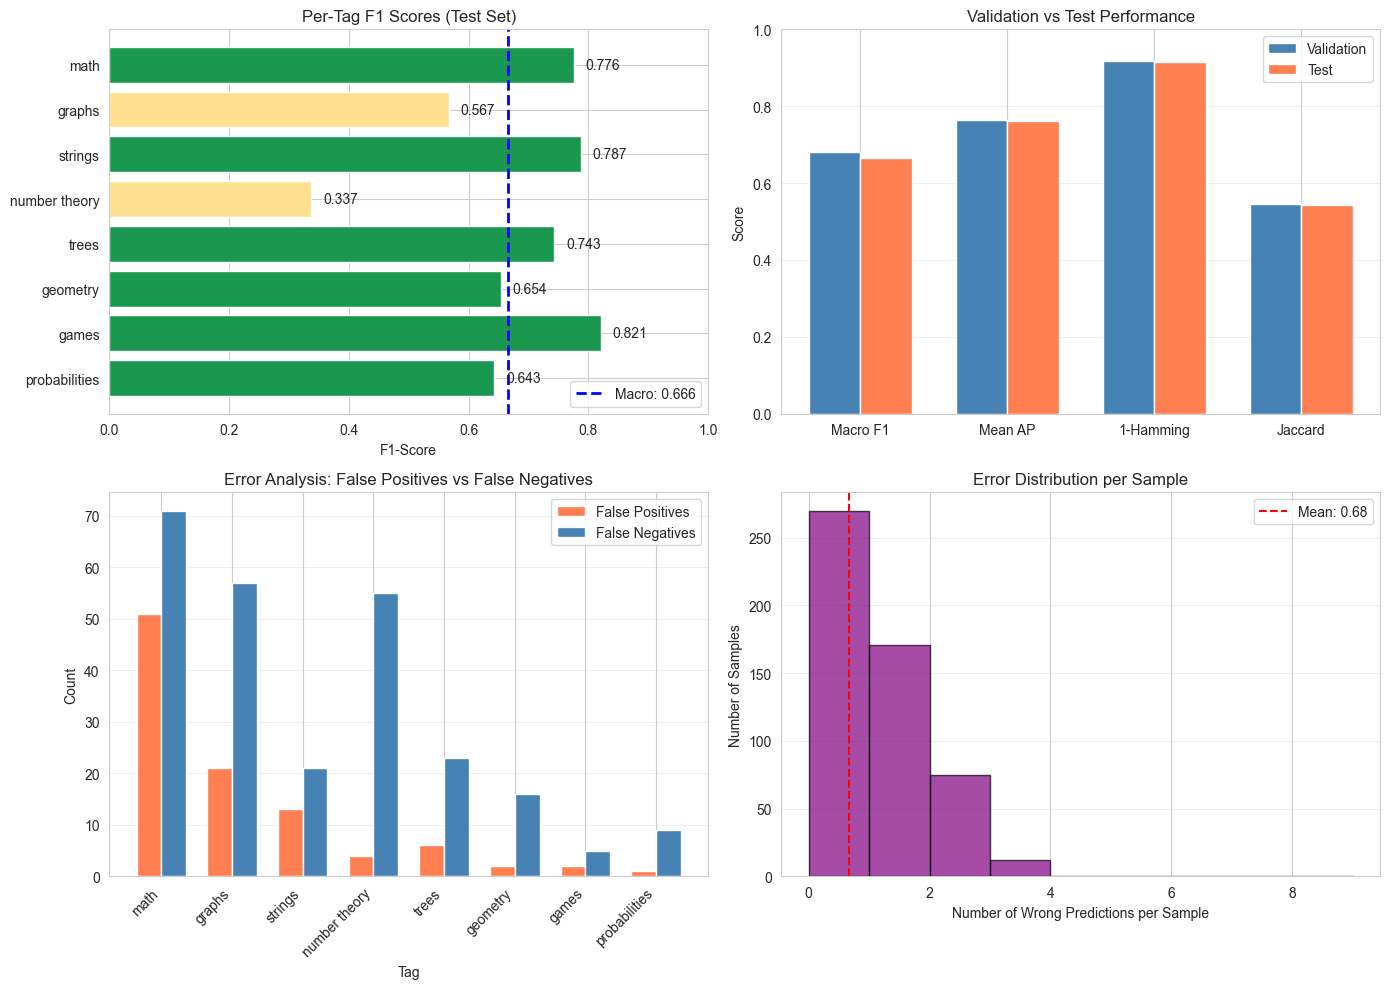

Visualization saved as 'multimodal_results.png'


In [ ]:

# Some Vizualisation

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Per-tag F1 scores
ax = axes[0, 0]
colors = ['#d73027' if f1 < 0.3 else '#fee090' if f1 < 0.6 else '#1a9850' for f1 in per_tag_f1]
bars = ax.barh(TARGET_TAGS, per_tag_f1, color=colors)
ax.set_xlabel('F1-Score')
ax.set_title('Per-Tag F1 Scores (Test Set)')
ax.set_xlim([0, 1])
ax.axvline(test_macro_f1, color='blue', linestyle='--', linewidth=2, label=f'Macro: {test_macro_f1:.3f}')
ax.legend()
ax.invert_yaxis()
for bar, f1 in zip(bars, per_tag_f1):
    ax.text(f1 + 0.02, bar.get_y() + bar.get_height()/2, f'{f1:.3f}', va='center')

# Validation vs Test comparison
ax = axes[0, 1]
metrics_val = [macro_f1, mean_ap, 1-hamming, jaccard]
metrics_test = [test_macro_f1, test_mean_ap, 1-test_hamming, test_jaccard]
metric_names = ['Macro F1', 'Mean AP', '1-Hamming', 'Jaccard']
x = np.arange(len(metric_names))
width = 0.35
ax.bar(x - width/2, metrics_val, width, label='Validation', color='steelblue')
ax.bar(x + width/2, metrics_test, width, label='Test', color='coral')
ax.set_ylabel('Score')
ax.set_title('Validation vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Confusion pattern (FP vs FN)
ax = axes[1, 0]
fp_counts = []
fn_counts = []
for i in range(len(TARGET_TAGS)):
    fp = ((y_test_pred[:, i] == 1) & (y_test[:, i] == 0)).sum()
    fn = ((y_test_pred[:, i] == 0) & (y_test[:, i] == 1)).sum()
    fp_counts.append(fp)
    fn_counts.append(fn)

x = np.arange(len(TARGET_TAGS))
width = 0.35
ax.bar(x - width/2, fp_counts, width, label='False Positives', color='coral')
ax.bar(x + width/2, fn_counts, width, label='False Negatives', color='steelblue')
ax.set_xlabel('Tag')
ax.set_ylabel('Count')
ax.set_title('Error Analysis: False Positives vs False Negatives')
ax.set_xticks(x)
ax.set_xticklabels(TARGET_TAGS, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Per-sample error distribution
ax = axes[1, 1]
sample_errors = np.sum(y_test != y_test_pred, axis=1)
ax.hist(sample_errors, bins=range(0, len(TARGET_TAGS)+2), color='purple', edgecolor='black', alpha=0.7)
ax.set_xlabel('Number of Wrong Predictions per Sample')
ax.set_ylabel('Number of Samples')
ax.set_title('Error Distribution per Sample')
ax.axvline(sample_errors.mean(), color='red', linestyle='--', label=f'Mean: {sample_errors.mean():.2f}')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('multimodal_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [122]:
# Save models for CLI
print("Saving Models")

with open(OUTPUT_DIR / 'xgb_models.pkl', 'wb') as f:
    pickle.dump(models, f)

# Save preprocessing
with open(OUTPUT_DIR / 'tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open(OUTPUT_DIR / 'difficulty_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save metadata
metadata = {
    'target_tags': TARGET_TAGS,
    'codebert_model': CODEBERT_MODEL,
    'max_code_length': MAX_CODE_LENGTH,
    'tfidf_features': X_train_tfidf.shape[1],
    'code_features': X_train_code.shape[1],
    'difficulty_features': 1,
    'total_features': X_train.shape[1],
    'median_difficulty': float(median_diff),
    'val_macro_f1': float(macro_f1),
    'val_mean_ap': float(mean_ap),
    'test_macro_f1': float(test_macro_f1),
    'test_mean_ap': float(test_mean_ap)
}

with open(OUTPUT_DIR / 'metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)


Saving Models


The final model configuration is :
- Features: 3769 dimensions
    - TF-IDF: 3000 dims
    - CodeBERT: 768 dims
    - Difficulty: 1 dim
  Models: 8 XGBoost classifiers (one per tag)

In [126]:
# Summary 

print("\nPerformance Summary:")
print(f"  Validation Set:")
print(f"    Macro F1: {macro_f1:.4f}")
print(f"    Mean AP:  {mean_ap:.4f}")
print(f"  Test Set:")
print(f"    Macro F1: {test_macro_f1:.4f}")
print(f"    Mean AP:  {test_mean_ap:.4f}")

print("\nBest Performing Tags (F1 > 0.6):")
best_tags = [(TARGET_TAGS[i], per_tag_f1[i]) for i in range(len(TARGET_TAGS)) if per_tag_f1[i] > 0.6]
for tag, f1 in sorted(best_tags, key=lambda x: x[1], reverse=True):
    print(f"  {tag:15s}: {f1:.3f}")
print("\nMost Challenging Tags (F1 < 0.5):")
worst_tags = [(TARGET_TAGS[i], per_tag_f1[i]) for i in range(len(TARGET_TAGS)) if per_tag_f1[i] < 0.5]
for tag, f1 in sorted(worst_tags, key=lambda x: x[1]):
    print(f"  {tag:15s}: {f1:.3f}")


Performance Summary:
  Validation Set:
    Macro F1: 0.6821
    Mean AP:  0.7636
  Test Set:
    Macro F1: 0.6659
    Mean AP:  0.7623

Best Performing Tags (F1 > 0.6):
  games          : 0.821
  strings        : 0.787
  math           : 0.776
  trees          : 0.743
  geometry       : 0.654
  probabilities  : 0.643

Most Challenging Tags (F1 < 0.5):
  number theory  : 0.337
